In [341]:
import rasterio
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import osgeo
from osgeo import gdal, osr
import os
from pyrsgis import raster
from pyrsgis.convert import changeDimension

In [342]:
# Read input image
image = r'C:\Users\jneuj\Dropbox\6. GIS\projects\LC Sebha\GEE\L5_2010.tif'
ds1, arr = raster.read(image, bands='all')

In [343]:
# Get metadata of source geotiff for georeferencing for Tiff export
orig = gdal.Open(image)
gT = orig.GetGeoTransform()
proj = orig.GetProjection()

In [344]:
# Check shape of sat image
initShape = arr.shape
print("Initial multispectral image shape: ", initShape)

# Reshape the image to have heigh*width rows and 2 cols (2 bands in the image and 2 input nodes)
arr = changeDimension(arr)
nBands = arr.shape[1]
print("Output multispectral image shape: ", arr.shape)


Initial multispectral image shape:  (7, 631, 533)
Bangalore multispectral image shape:  (336323, 7)


In [345]:
arr.shape

(336323, 7)

In [346]:
# Read training polygon
fp = r"C:\Users\jneuj\Dropbox\6. GIS\projects\LC Sebha\test2\trainingTest2Good4326.shp"
map_df = gpd.read_file(fp)
print(map_df.crs)

# Setup training data and validation data
xtrain = map_df[['b1_L5_2010', 'b2_L5_2010', 'b3_L5_2010', 'b4_L5_2010', 'b5_L5_2010', 'b6_L5_2010', 'b7_L5_2010']]
ytrain = map_df[['classvalue']]

# Normalize training data
norm1 = xtrain.max()
xtrain = (xtrain/(norm1.tolist()))

# Normalize original image
norm2 = np.amax(arr, axis=0)
arr = (arr/(norm2))

{'init': 'epsg:4326'}


In [363]:
# Turn the labels into an array
y = np.ravel(ytrain)
X_train, X_test, y_train, y_test = train_test_split(xtrain, y, test_size=0.30, random_state=42)

# Change data format from pandas dataframe to numpy array
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# Reshape the data
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
arr = arr.reshape((arr.shape[0], 1, arr.shape[1]))

In [350]:
X_train.shape

(577, 1, 7)

In [351]:
# Build an artifical neural network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units = 12, activation = 'relu', input_shape = (1,nBands)))
#model.add(tf.keras.layers.Dense(units = 12, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(units = 10, activation = 'relu'))
model.add(tf.keras.layers.Dense(units=3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

model.summary()



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 1, 12)             96        
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 12)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 1, 10)             130       
_________________________________________________________________
dense_21 (Dense)             (None, 1, 3)              33        
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________


In [352]:
# Fit the model and asses accuracy
model.fit(X_train,y_train,epochs = 70)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy: {}".format(test_accuracy))

Train on 577 samples
Epoch 1/70
577/577 [==============================] - 1s 1ms/sample - loss: 1.1132 - sparse_categorical_accuracy: 0.3674
Epoch 2/70
577/577 [==============================] - 0s 57us/sample - loss: 1.0968 - sparse_categorical_accuracy: 0.3795
Epoch 3/70
577/577 [==============================] - 0s 57us/sample - loss: 1.0855 - sparse_categorical_accuracy: 0.4402
Epoch 4/70
577/577 [==============================] - 0s 56us/sample - loss: 1.0806 - sparse_categorical_accuracy: 0.4974
Epoch 5/70
577/577 [==============================] - 0s 54us/sample - loss: 1.0732 - sparse_categorical_accuracy: 0.5217
Epoch 6/70
577/577 [==============================] - 0s 55us/sample - loss: 1.0623 - sparse_categorical_accuracy: 0.5581
Epoch 7/70
577/577 [==============================] - 0s 54us/sample - loss: 1.0636 - sparse_categorical_accuracy: 0.5459
Epoch 8/70
577/577 [==============================] - 0s 62us/sample - loss: 1.0493 - sparse_categorical_accuracy: 0.5425
Epoc

In [291]:
# Model is maybe heavily overfit, but let's keep it for now
model_json = model.to_json()
with open("fashion_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("fashion_model.h5")

In [358]:
yTestPredicted[:,:,1]

array([[0.05797839],
       [0.06204846],
       [0.01649527],
       [0.8554866 ],
       [0.15635948],
       [0.1454128 ],
       [0.8282126 ],
       [0.7992469 ],
       [0.00898863],
       [0.0473166 ],
       [0.15125437],
       [0.03187494],
       [0.75056815],
       [0.07121651],
       [0.8625857 ],
       [0.45419317],
       [0.8271439 ],
       [0.01101935],
       [0.3686854 ],
       [0.17070979],
       [0.03086006],
       [0.18081968],
       [0.09431686],
       [0.15562041],
       [0.64061856],
       [0.71736413],
       [0.22280662],
       [0.7966809 ],
       [0.15284073],
       [0.31926033],
       [0.5799381 ],
       [0.20877732],
       [0.13204187],
       [0.19030237],
       [0.00954553],
       [0.16137126],
       [0.921449  ],
       [0.921449  ],
       [0.7735373 ],
       [0.1332178 ],
       [0.8863199 ],
       [0.01226   ],
       [0.01101935],
       [0.93526447],
       [0.84511524],
       [0.08023556],
       [0.06138662],
       [0.175

In [361]:

from sklearn.metrics import confusion_matrix, precision_score, recall_score
# MODIFY THIS CODE TO HAVE AN IDEA OF TEST ACCURACY AND LOOK BACK TO ARTICLE
# Predict for test data 
yTestPredicted = model.predict(X_test)
yTestPredicted = yTestPredicted[:,:,1]  #yTestPredicted[:,1]

# Calculate and display the error metrics
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(y_test, yTestPredicted)
#pScore = precision_score(y_test, yTestPredicted)
#rScore = recall_score(y_test, yTestPredicted)

print("Confusion matrix: for 14 nodes\n", cMatrix)
#print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))

Confusion matrix: for 14 nodes
 [[101   0   0]
 [  5  75   0]
 [ 67   0   0]]


In [401]:
pred = model.predict(arr)
pred.shape

(336323, 1, 3)

In [402]:
pred0 = pred[:,:,0]  #Why is this different in the article?
pred1 = pred[:,:,1]
pred2 = pred[:,:,2]

In [397]:
pred.shape

(336323, 1)

In [404]:
output0 = np.reshape(pred0,  (ds1.RasterYSize, ds1.RasterXSize))
output1 = np.reshape(pred1,  (ds1.RasterYSize, ds1.RasterXSize))
output2 = np.reshape(pred2,  (ds1.RasterYSize, ds1.RasterXSize))
output0.shape

(631, 533)

In [406]:
outFile0 = r"C:\Users\jneuj\Dropbox\6. GIS\projects\LC Sebha\test2\try0.tiff"
raster.export(output0, ds1, filename=outFile0, dtype='float')

outFile1 = r"C:\Users\jneuj\Dropbox\6. GIS\projects\LC Sebha\test2\try1.tiff"
raster.export(output1, ds1, filename=outFile1, dtype='float')

outFile2 = r"C:\Users\jneuj\Dropbox\6. GIS\projects\LC Sebha\test2\try2.tiff"
raster.export(output2, ds1, filename=outFile2, dtype='float')

In [372]:
ds3

NameError: name 'ds3' is not defined

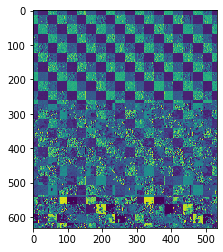

In [298]:
jippie = output[0,:,:]
plt.imshow(jippie)
plt.show()

In [299]:
# -*- coding: utf-8 -*-
def CreateGeoTiff(Name, Array, NDV, 
                  GeoT, proj):
    Array[np.isnan(Array)] = NDV
    driver = gdal.GetDriverByName('GTiff')
    DataSet = driver.Create(Name, Array.shape[2], Array.shape[1], Array.shape[0], gdal.GDT_Float32)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(proj )
    for i, image in enumerate(Array, 1):
        DataSet.GetRasterBand(i).WriteArray( image )
        DataSet.GetRasterBand(i).SetNoDataValue(NDV)
    DataSet.FlushCache()
    return Name

os.environ['SHAPE_ENCODING'] = "utf-8"
hope = CreateGeoTiff(r"C:\Users\jneuj\Dropbox\6. GIS\projects\LC Sebha\test2\testoutput2Joost.tiff", output, -99, gT, proj)

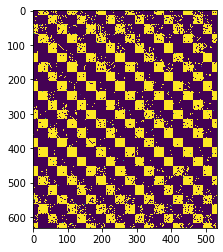

In [106]:
src = rasterio.open(r"C:\Users\jneuj\Dropbox\6. GIS\projects\LC Sebha\test2\testoutput2Joost.tiff")
plt.imshow(src.read(2), cmap='viridis')
plt.show()

In [ ]:

from pyrsgis import raster
outFile = 'C:\Users\jneuj\Dropbox\6. GIS\projects\LC Sebha\test2\testoutput3Joost.tiff'
raster.export(output, ds3, filename=outFile, dtype='float')